In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_theme()

In [3]:
df = pd.read_csv('data/main-processed.tsv', sep='\t')
df['log_tc'] = df['tc'].apply(lambda x: np.log(x))

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, Normalizer
from sklearn.metrics import mean_absolute_error

import category_encoders as ce

In [5]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date', ascending=True).reset_index(drop=True)

In [6]:
partitions = []

idxs = np.linspace(0, len(df), 17, dtype=int)
for st, ed in zip(idxs, idxs[1:]):
    partitions.append(df.iloc[st:ed].copy())

In [7]:
pl = Pipeline([
('ct', ColumnTransformer([
    ('impute', SimpleImputer(strategy='median'), ['yoe_total']),
    #('onehot', OneHotEncoder(min_frequency=10, handle_unknown='infrequent_if_exist'), ['company', 'location', 'level_name']),
    ('target', ce.TargetEncoder(), ['company', 'location', 'level_name']),
], remainder='drop')),
('reg', LinearRegression())
])

In [8]:
from collections import defaultdict
import matplotlib.gridspec as gridspec


In [29]:
p_vals = [0, 0.3, 0.5, 0.7] # Probability to 'agree on salary' - replace what is seen in data with model prediction
s_vals = [0.3, 0.7, 0.9] # Magniutde of noise added to predictions

results = {}
for p in p_vals:
    results[p] = {}
    p_dict = results[p]
    for s in s_vals:
        p_dict[s] = defaultdict(list)
        s_dict = p_dict[s]
        for i in range(len(partitions)):
            
            if i > 0:
                cur = pd.concat([partitions[i-1], partitions[i]])
            else:
                cur = partitions[i]
            X = cur.drop(['tc', 'base', 'stock', 'bonus', 'log_tc'], axis=1)
            y = cur['log_tc']

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
            
            pl.fit(X_train, y_train)
            r2 = pl.score(X_test, y_test)
            mae = mean_absolute_error(y_test, pl.predict(X_test))
            s_dict['r2'].append(r2)
            s_dict['mae'].append(mae)
            #print(f"Partition {i}: R2 = {r2}, MAE = {mae}")
            
            if i+1 < len(partitions):
                #Predict with current model
                nxt = partitions[i+1]
                nxt['rand'] = np.random.rand(len(nxt))
                nxt['preds'] = pl.predict(nxt.drop(['tc', 'base', 'stock', 'bonus', 'log_tc'], axis=1))
                
                #Add noise
                std = nxt['log_tc'].std()
                nxt['noise'] = np.random.normal(0, s*std, len(nxt))
                
                nxt.loc[nxt['rand'] < p, 'log_tc'] = nxt.loc[nxt['rand'] < p, 'preds'] + nxt.loc[nxt['rand'] < p, 'noise']

C:\Users\Lily\AppData\Local\Temp\ipykernel_21532\3071501665.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(h_pad=-1)


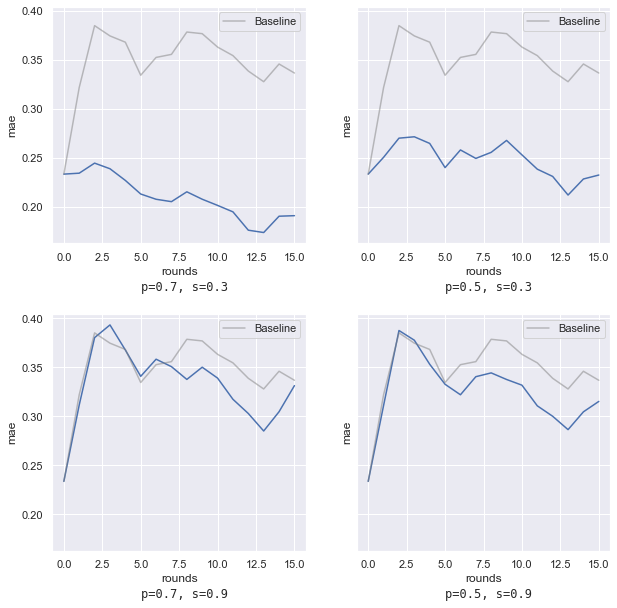

In [35]:
plot_vals = [(0.7, 0.3), (0.5, 0.3), (0.7, 0.9), (0.5, 0.9)]
fig, ax = plt.subplots(2,2, figsize=(10,10), gridspec_kw={'hspace': 0.3}, sharey=True)

for i, ps in enumerate(plot_vals):
    p, s = ps
    ax_i = ax[i // 2, i % 2]
    data = results[p][s]['mae']
    ax_i.plot(data)
    ax_i.plot(results[0][0.3]['mae'], color='grey', alpha=0.5, label='Baseline')
    ax_i.legend()
    ax_i.set_ylabel("mae")
    ax_i.set_xlabel("rounds")
    #ax_i.plot(s_dict['r2'], label=f"p={p}, s={s}")
    ax_i.text(0.35, -0.2, f"p={p}, s={s}", transform=ax_i.transAxes, fontfamily='monospace')

plt.tight_layout(h_pad=-1)
plt.savefig('./vis/dsc-167-2/feedback_loop.png', bbox_inches='tight')

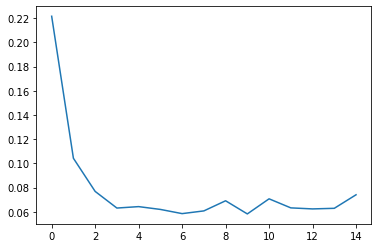

In [ ]:
plt.plot(results[0.7][0.3]['mae'])

In [ ]:
import argparse
import json
import os
from tqdm import tqdm

from experiment import *

parser = None
folder = 'experiment'
run_times = 1
random_seed = 0


def create_model(model_params):
    if 'lr' in model_params:
        model_name = 'lr'
        model = lambda : lr_model(**model_params['lr'])
        print(f"Using model: {model_name}")
        yield model, model_name
    # if 'gbr_model' in model_params:
    #     model_name = 'gbr'
    #     model = lambda : gbr_model(**model_params['gbr_model'])
    #     print(f"Using model: {model_name}")
    #     yield model, model_name
    # if 'ridge_model' in model_params:
    #     model_name = 'ridge'
    #     model = lambda : ridge_model(**model_params['ridge_model'])
    #     print(f"Using model: {model_name}")
    #     yield model, model_name


def single_model(model_params, params):
    print(f"Running single-model experiment")
    X, y, _ = get_dataset()
    for model, model_name in create_model(model_params):
        for trial in tqdm(range(0, run_times)):
            os.makedirs(f"{folder}/{trial}", exist_ok=True)
            single_model_experiment(X, y, model, model_name=f"{folder}/{trial}/{model_name}", **params)
print(f"Running hidden-loop experiment")
X, y, _ = get_dataset()

def hidden_loop(model_params, params):
    for model, model_name in create_model(model_params):
        results = MultipleResults(model_name, **HiddenLoopExperiment.default_state)

        for trial in tqdm(range(0, run_times)):
            hle = HiddenLoopExperiment(X, y, model, model_name)
            hle.prepare_data(p)

            hle.hidden_loop_experiment(adherence=0.2, usage=0.1, step=10)

            results.add_results(**vars(hle))

        results.plot_multiple_results(folder)


Running hidden-loop experiment


In [ ]:
model_dict = {'lr': {}}
params_dict = {'train_size': 0.3}